In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns
from scipy.signal import savgol_filter
from scipy.io import loadmat
%matplotlib inline

In [2]:
FILE_WAY = '/kaggle/input/nasa-battery-dataset/cleaned_dataset/'
metadata = pd.read_csv(f'{FILE_WAY}metadata.csv')
metadata.head()  # Capacity ~ SOH. for SOH estimation select discharge data


,type,start_time,ambient_temperature,battery_id,test_id,uid,filename,Capacity,Re,Rct
0,discharge,[2010. 7. 21. 15. 0. ...,4,B0047,0,1,00001.csv,1.6743047446975208,NaN,NaN
1,impedance,[2010. 7. 21. 16. 53. ...,24,B0047,1,2,00002.csv,NaN,0.05605783343888099,0.20097016584458333
2,charge,[2010. 7. 21. 17. 25. ...,4,B0047,2,3,00003.csv,NaN,NaN,NaN
3,impedance,[2010 7 21 20 31 5],24,B0047,3,4,00004.csv,NaN,0.05319185850921101,0.16473399914864734
4,discharge,[2.0100e+03 7.0000e+00 2.1000e+01 2.1000e+01 2...,4,B0047,4,5,00005.csv,1.5243662105099023,NaN,NaN


In [ ]:
class Battery:
    """NASA battery data loader and processor."""
    
    def __init__(self, bat_id, to_sort = False, tensor = False, 
                 crop = None, drop_time = False):
        """
        Args:
            bat_id: Battery ID from metadata
            to_sort: Sort capacity values if True
            tensor: Convert to PyTorch tensors if True  
            crop: Crop cycles to this length
            drop_time: Remove Time column if True
        """
        self.tensor = tensor
        self.bat_id = bat_id
        mask = (metadata['battery_id'] == self.bat_id) & (metadata['type'] == 'discharge')
        self.capacity =  metadata.loc[mask].copy()
        self.capacity.loc[:, 'Capacity'] = pd.to_numeric(self.capacity['Capacity']) / 2.0 # init capacity
        
        if to_sort:
            self.capacity = self.capacity.sort_values('Capacity')
            
        self.y = np.array(self.capacity['Capacity'], dtype=float)
        
        if tensor:
            self.y = torch.tensor(self.y, dtype=torch.float32)

        self._clean_data()
        self._get_data(crop=crop, drop_time=drop_time)
        self._ica_features()

    def _clean_data(self):
        """Очистка данных - исправленная версия"""
        self.cleaned_tables = []
        
        for file in self.capacity['filename']:
            table = pd.read_csv(f'{FILE_WAY}/data/{file}')
            table_array = table.values  
            
        
            min_v_ind = table_array[:, 0].argmin()
            min_time = table_array[min_v_ind, -1]   
            
        
            mask = table_array[:, -1] < min_time 
            self.cleaned_tables.append(table_array[mask])
        
        

    def _get_data(self, crop, drop_idx=[2]): 
        '''
        crop random points from table
        '''
        self.table = []
        index = []
        for ind, table in enumerate(self.cleaned_tables):   
            indexes = [i for i in range(6) if i not in drop_idx]
            table = table[:, indexes]
                
            if crop is None:
                self.table.append(np.array(table))
                index.append(ind)
            elif table.shape[0] >= crop:
                # randomly delete data 
                mask = np.random.permutation([True] * crop + [False] * (table.shape[0] - crop))
                self.table.append(table[mask])
                index.append(ind)

        self.y = self.y[index]

        self.table = np.array(self.table)
        
        
    def _ica_features(self):
        '''
        obtain ICA_data from cleaned tablestable
        '''
        max_volt = 4.2
        min_voltages = {5: 2.7, 6: 2.7, 7: 2.2, 18: 2.5} # from additional data
        min_volt = min_voltages[int(self.bat_id[2:])]
        features = []
        dqdv = []
        voltage_all = []
        
        
        for tab, ind in zip(self.cleaned_tables, self.index):
            if ind not in self.index:
                continue
            voltage = tab[:, 0]  
            current = tab[:, 1]  
            time = tab[:, -1]  
    
            # filter by cut_off voltage
            mask = (voltage >= min_volt) & (voltage <= max_volt)
            voltage = voltage[mask]
            current = current[mask]
            time = time[mask]
            
            dt = np.diff(time, prepend=time[0]) / 3600  
    
            Q = np.cumsum(np.abs(current) * dt)
    
            dQ = np.gradient(Q)
            dV = np.gradient(voltage)
            dQ_dV = dQ / dV
    
            dQ_dV_smooth = savgol_filter(dQ_dV, window_length=30 , polyorder=2)
    
            peak_height = np.min(dQ_dV_smooth)
            peak_idx = np.argmin(dQ_dV_smooth)
            peak_voltage = voltage[peak_idx]  
            area_under_curve = np.trapz(dQ_dV_smooth, voltage)
    
            features.append([peak_height, peak_voltage, area_under_curve]) 

            new_len = min(len(dQ_dV_smooth), len(tab))
            dqdv.append(dQ_dV_smooth[:new_len])
            voltage_all.append(voltage[:new_len])
  
        self.ica = np.array(features)
        self.ica = self.ica
        self.dqdv = dqdv
        self.volt = voltage_all

    def build_ica(self, diap=(float('-inf'), float('inf'))):
        fig, ax = plt.subplots()
        for v, ic in zip(self.volt, self.dqdv):
            mask = (v > diap[0]) & (v < diap[1])
            ax.plot(v[mask], 1000 * ic[mask])
            dqdv_max = ic.min()
            v_max = v[ic.argmin()]
            ax.plot(v_max, 1000 * dqdv_max, marker='*', color='red')
        ax.set_xlabel(r'Voltage (V)', fontsize=15)
        ax.set_ylabel(r'dQ/dV (mAh/V)', fontsize=15)
        ax.set_title(f'All ica for {self}')
            
    def __str__(self):
        return f"Battery_{int(self.bat_id[-2:])}"

        

def results(y_test: np.ndarray, y_pred: np.ndarray, ax: plt.Axes = None, 
           label: str = '') -> dict:
    """
    Plot and calculate metrics for SOH predictions.
    
    Returns:
        dict with r2, rmse, mae metrics
    """
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    print(f'R2 score = {r2:.3f}')
    print(f'rmse = {100 * rmse:.3f}%')
    print(f'mae = {mae:.3f}')
    if ax is None:
        fig, ax = plt.subplots(figsize=(15,15))
    cycles = np.arange(1, len(y_test) + 1)
    ax.plot(cycles, y_test, color='red', label='Test SOH')
    ax.plot(cycles, y_pred, color='green', label='Predicted SOH')
    ax.set_xlabel('Cycle', fontsize=20)
    ax.set_ylabel('SOH', fontsize=20)
    ax.set_title(label, fontsize=20)
    plt.grid()
    ax.legend(fontsize=15)
    return {'r2': r2, 'rmse': rmse, 'mae': mae}




In [4]:
discharge_data_example = pd.read_csv(f'{FILE_WAY}data/00001.csv')
print(discharge_data_example.shape)
discharge_data_example.head(10)

(490, 6)


,Voltage_measured,Current_measured,Temperature_measured,Current_load,Voltage_load,Time
0,4.246711,0.000252,6.212696,0.0002,0.000,0.000
1,4.246764,-0.001411,6.234019,0.0002,4.262,9.360
2,4.039277,-0.995093,6.250255,1.0000,3.465,23.281
3,4.019506,-0.996731,6.302176,1.0000,3.451,36.406
4,4.004763,-0.992845,6.361645,1.0000,3.438,49.625
5,3.992863,-0.995957,6.399692,1.0000,3.427,62.813
6,3.982347,-0.994665,6.233613,1.0000,3.419,75.891
7,3.972458,-0.998753,5.984854,1.0000,3.400,89.031
8,3.963740,-0.994140,5.857702,1.0000,3.391,102.141
9,3.955432,-0.993797,5.772313,1.0000,3.386,115.297


In [5]:
bat7 = Battery('B0007', crop=10)
min_crop = min([i.shape[0] for i in bat7.cleaned_tables])

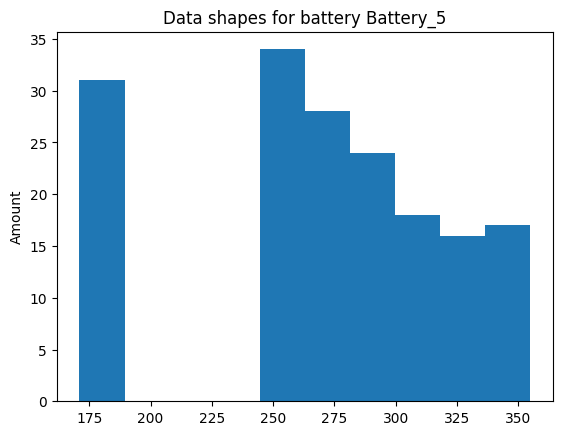

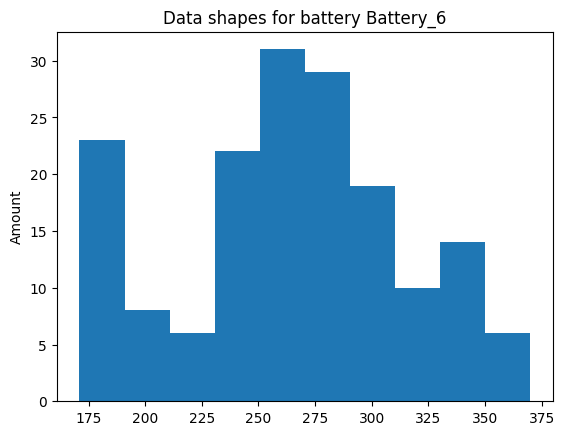

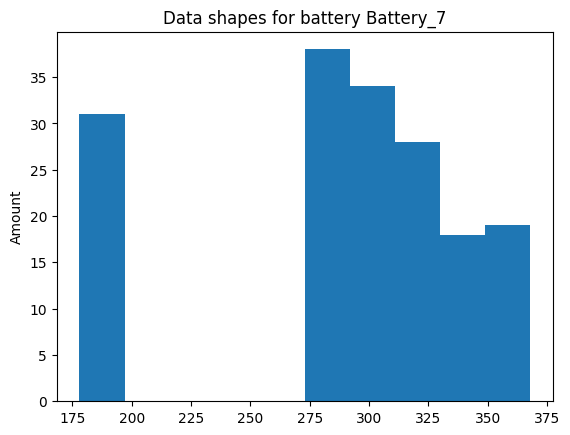

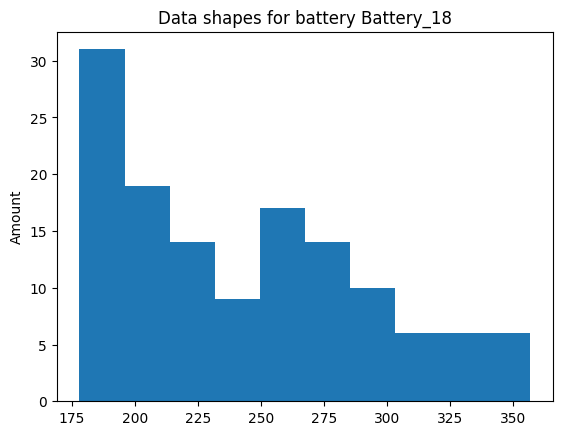

In [65]:
bat5 = Battery('B0005', crop=min_crop)
bat6 = Battery('B0006', crop=min_crop)
bat7 = Battery('B0007', crop=min_crop)
bat18 = Battery('B0018', crop=min_crop)
bats = [bat5, bat6, bat7, bat18]
for bat in bats:
    shapes = []
    for i in bat.cleaned_tables:
        shapes.append(i.shape[0])
    plt.hist(shapes)
    plt.title(f'Data shapes for battery {str(bat)}')
    plt.ylabel('Amount')
    plt.show('Shape')
        

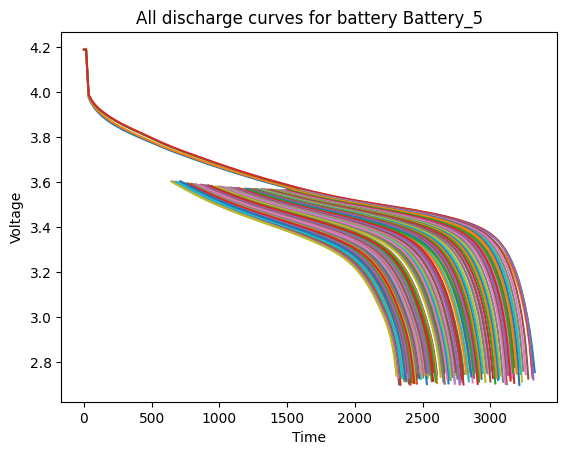

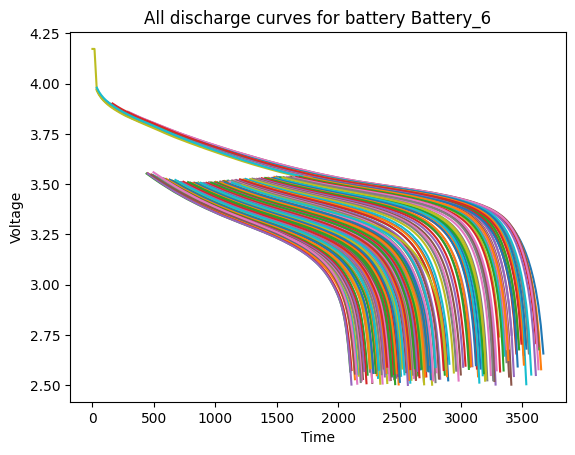

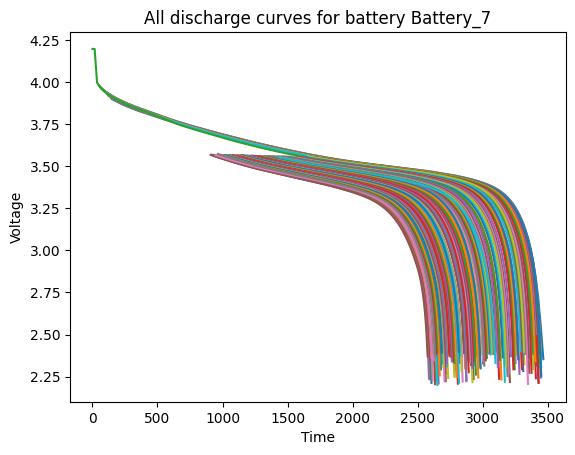

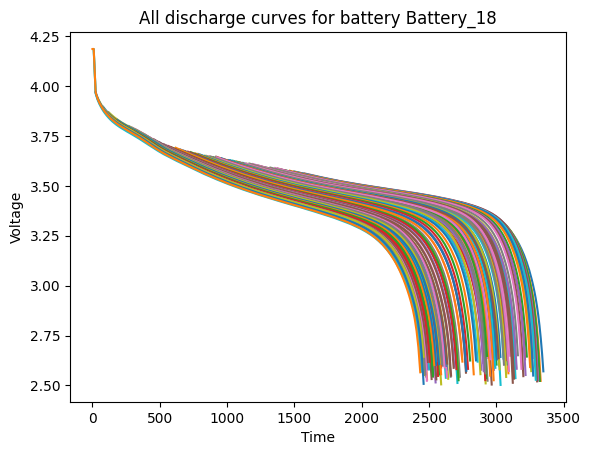

In [36]:
# cut data from begin, because knee point is important
for bat in bats:
    fig, ax = plt.subplots()
    for i in bat.table:
        ax.plot(i[:, -1], i[:, 0]) # time - voltage
    ax.set_xlabel('Time')
    ax.set_ylabel('Voltage')
    ax.set_title(f'All discharge curves for battery {str(bat)}')
    plt.show()

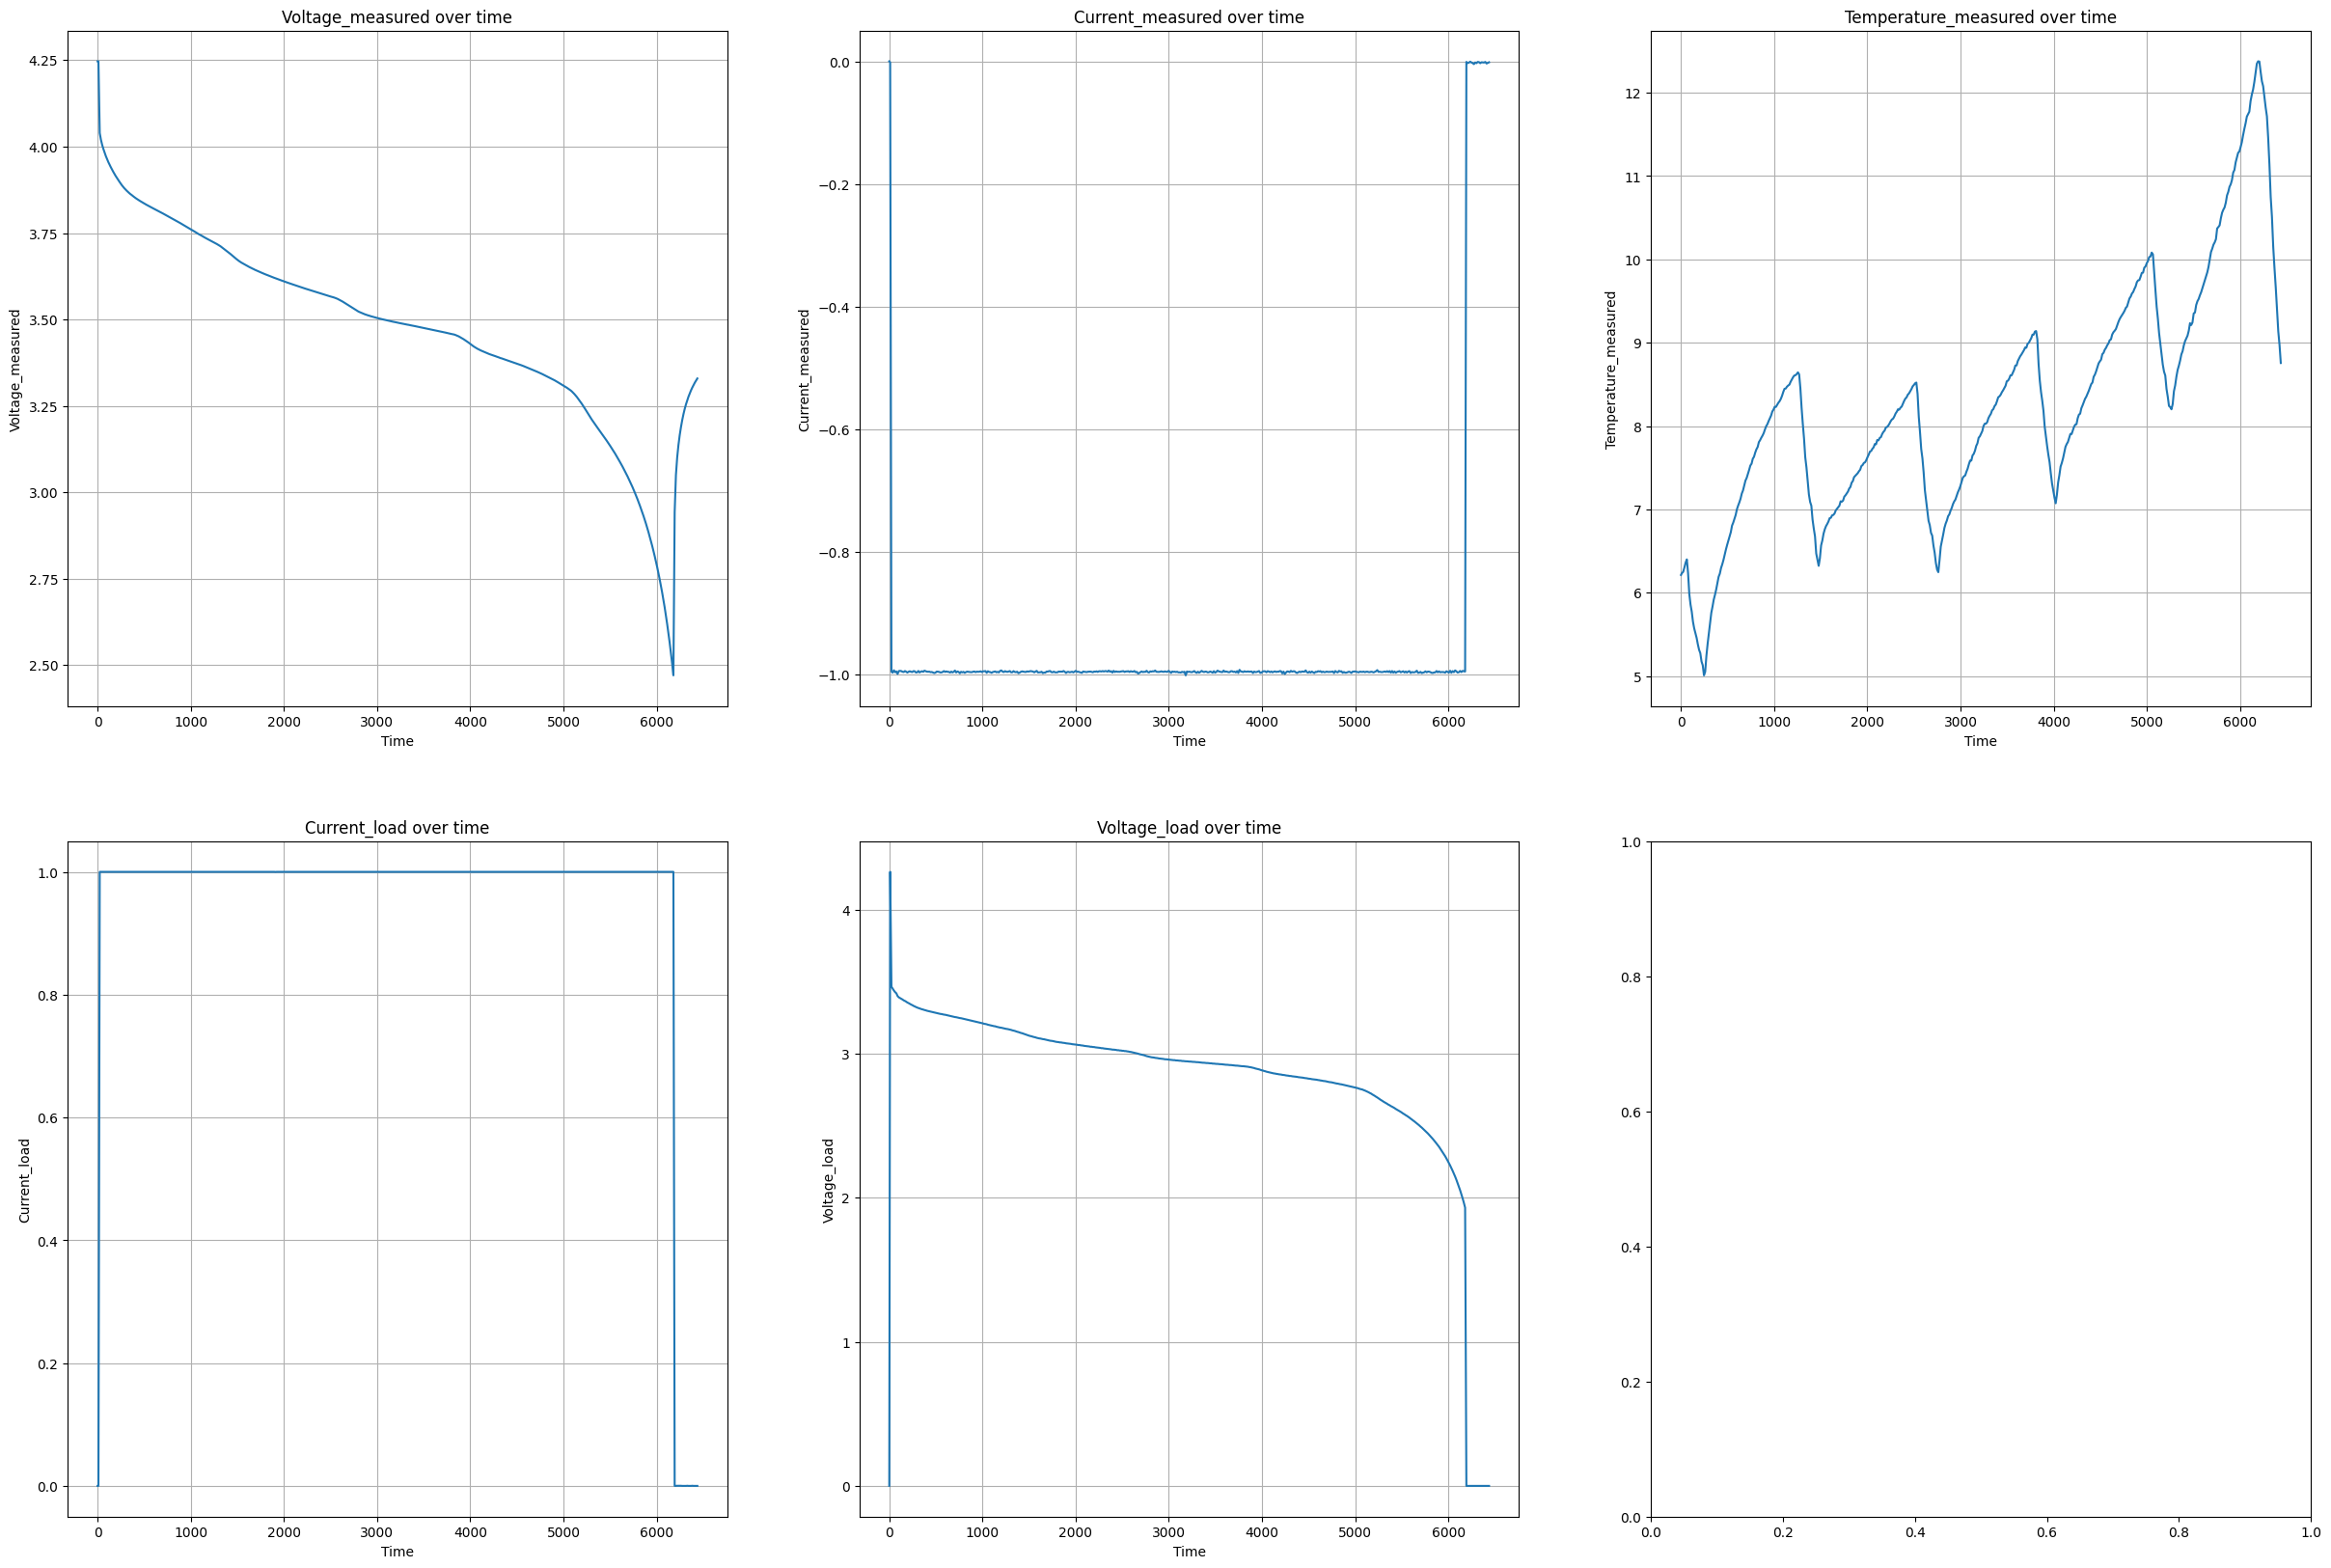

In [64]:
# plot graphs of measured data over time
fig, axes = plt.subplots(2, 3, figsize=(30, 20))
for ax, col in zip(axes.flatten(), discharge_data_example.columns[:-1]):
    ax.plot(discharge_data_example['Time'], discharge_data_example[col])
    ax.set_title(f'{col} over time')
    ax.set_xlabel('Time')
    ax.set_ylabel(col)
    ax.grid()

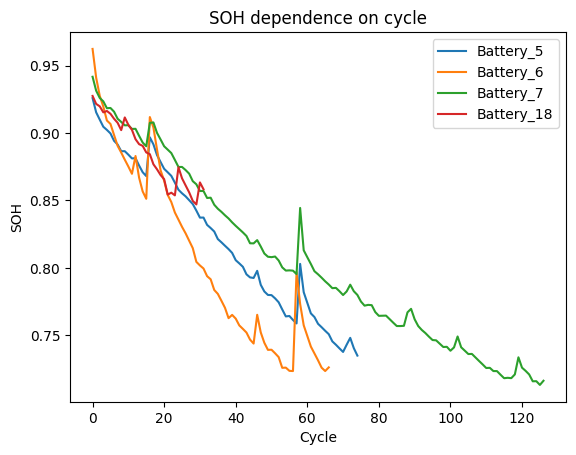

In [14]:
# in our study we use batteries 5, 6 for study, battery 7 for test, battery 18 for validatation
fig, ax = plt.subplots()

for bat in bats:
    ax.plot(bat.y, label=str(bat))

ax.set_ylabel('SOH')
ax.set_xlabel('Cycle')
ax.set_title('SOH dependence on cycle')
ax.legend()
plt.show()

train shape:  (142, 3)
[-5.24230898  3.47821525  1.75202478]


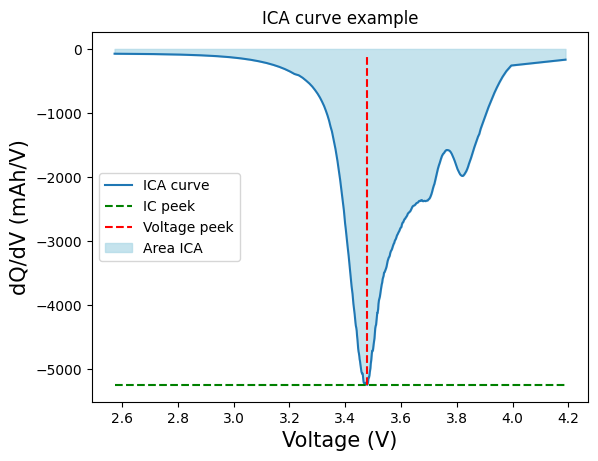

In [15]:
# Popular technique for extracting degradation-sensitive features is 
# Incremental Capacity Analysis (ICA), which provides interpretable descriptors
# of internal changes during cycling
def extract_ica_features(X, min_volt=2.4, max_volt=4.2):
    '''
    obtain ICA_data from table
    parameters: 
        X - vector of tables with discharge data
        min_volt - cut_off voltage
        max_volt = 4.2 - max voltage
        
    return: dQ/dV data,  voltage data, 
        ica features: peak hight, peak voltage, area under curve
    '''
    n_samples = X.shape[0]
    n_est = X.shape[1]
    features = []
    dqdv = np.zeros([X.shape[0], n_est])
    voltage_all = np.zeros([X.shape[0], n_est])
    
    

    for i in range(n_samples):
        voltage = X[i, :, 0]  
        current = X[i, :, 1]  
        time = X[i, :, -1]  

        # filter by cut_off voltage
        mask = (voltage >= min_volt) & (voltage <= max_volt)
        voltage = voltage[mask]
        current = current[mask]
        time = time[mask]
        
        dt = np.diff(time, prepend=time[0]) / 3600  

        Q = np.cumsum(np.abs(current) * dt)

        dQ = np.gradient(Q)
        dV = np.gradient(voltage)
        dQ_dV = dQ / dV

        dQ_dV_smooth = savgol_filter(dQ_dV, window_length=30 , polyorder=2)

        peak_height = np.min(dQ_dV_smooth)
        peak_idx = np.argmin(dQ_dV_smooth)
        peak_voltage = voltage[peak_idx]  
        area_under_curve = np.trapz(dQ_dV_smooth, voltage)

        features.append([peak_height, peak_voltage, area_under_curve])
        
        new_len = min(len(dQ_dV_smooth), n_est)
        dqdv[i, :new_len] = dQ_dV_smooth[:new_len]
        voltage_all[i, :new_len] = voltage[:new_len]
        
    return np.array(dqdv), np.array(voltage_all), np.array(features)

min_voltages = {5: 2.7, 6: 2.7, 7: 2.2, 18: 2.5} # from additional data

dqdv_train, v_tr, ica_train = extract_ica_features(np.concatenate([bat5.table, bat6.table], 0), min_volt=2.7)
dqdv_val, v_val, ica_val = extract_ica_features(bat18.table, min_volt=2.2)
dqdv_test, v_test, ica_test = extract_ica_features(bat7.table, min_volt=2.5)

print('train shape: ', ica_train.shape)
print(ica_val[-1])
INDEX_ICA = -1
plt.plot(v_val[INDEX_ICA],  1000 * dqdv_val[INDEX_ICA], label='ICA curve')

dqdv_data = np.linspace(dqdv_val[INDEX_ICA].min(), dqdv_val[INDEX_ICA].max(), 100)
v_data = np.linspace(v_val[INDEX_ICA].min(), v_val[INDEX_ICA].max(), 100)

plt.plot(v_data, [ica_val[INDEX_ICA][0] * 1000] * 100, ls='--', color='green', label='IC peek')
plt.plot([ica_val[INDEX_ICA][1]] * 100, dqdv_data * 1000, ls='--', color='red', label='Voltage peek')

plt.fill_between(v_val[INDEX_ICA], 1000 * dqdv_val[INDEX_ICA], color='lightblue', alpha=0.7, label='Area ICA')
plt.xlabel(r'Voltage (V)', fontsize=15)
plt.ylabel(r'dQ/dV (mAh/V)', fontsize=15)
plt.title('ICA curve example')
plt.legend()
plt.show()

In [48]:
def build_all_ica(dqdv, v, diap=(3, 3.8), title='All ICA for Battery 7'):
    fig, ax = plt.subplots()
    for i in range(v.shape[0]):
        mask = (v[i] > diap[0]) & (v[i] < diap[1])
        ax.plot(v[i][mask], 1000 * dqdv[i][mask])
        dqdv_max = dqdv[i].min()
        v_max = v[i][dqdv[i].argmin()]
        ax.plot(v_max, 1000 * dqdv_max, marker='*', color='red')
        ax.set_xlabel(r'Voltage (V)', fontsize=15)
        ax.set_ylabel(r'dQ/dV (mAh/V)', fontsize=15)
        ax.set_title(title)
        

(127, 280)
(142, 280)
(32, 280)


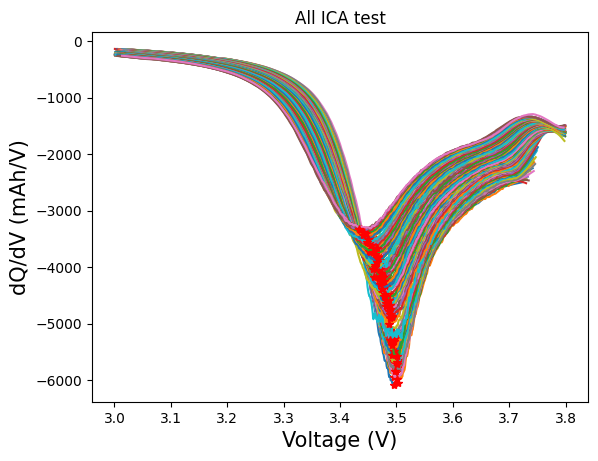

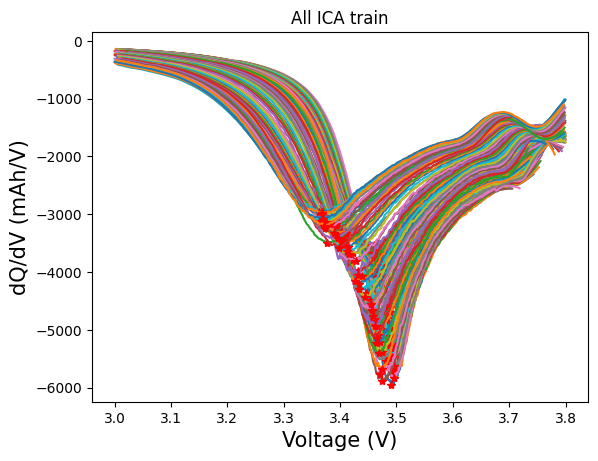

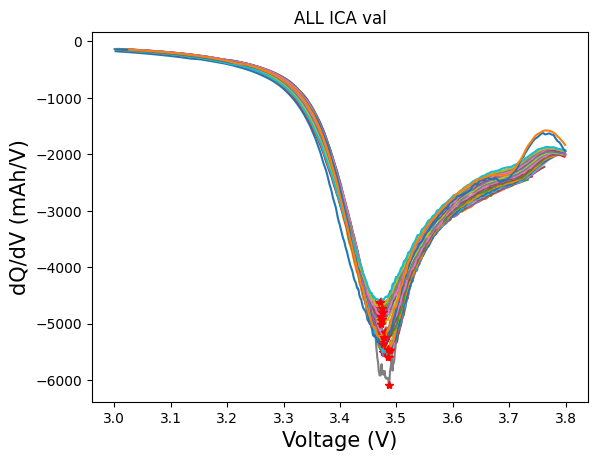

In [17]:
build_all_ica(dqdv_test, v_test, diap=(3, 3.8), title='All ICA test')
build_all_ica(dqdv_train, v_tr, diap=(3, 3.8), title='All ICA train')
build_all_ica(dqdv_val, v_val, diap=(3, 3.8), title='ALL ICA val')

<Axes: >

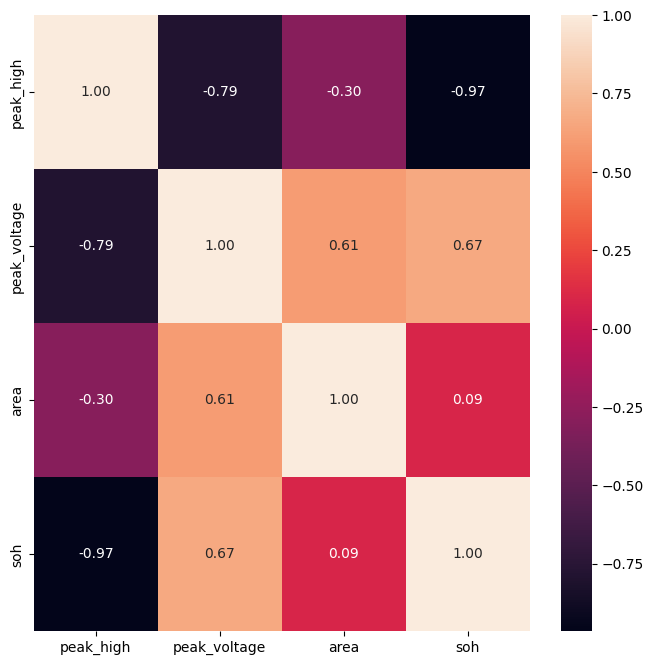

In [99]:
# Correlation between ica features and SOH
y_train = np.concatenate([bat5.y, bat6.y], 0)
corr = pd.DataFrame(np.concatenate([ica_train, y_train.reshape(-1, 1)], 1),
                    columns=['peak_high', 'peak_voltage', 'area', 'soh'])
plt.figure(figsize=(8, 8))
sns.heatmap(corr.corr(), annot=True, fmt='.2f')


<Axes: >

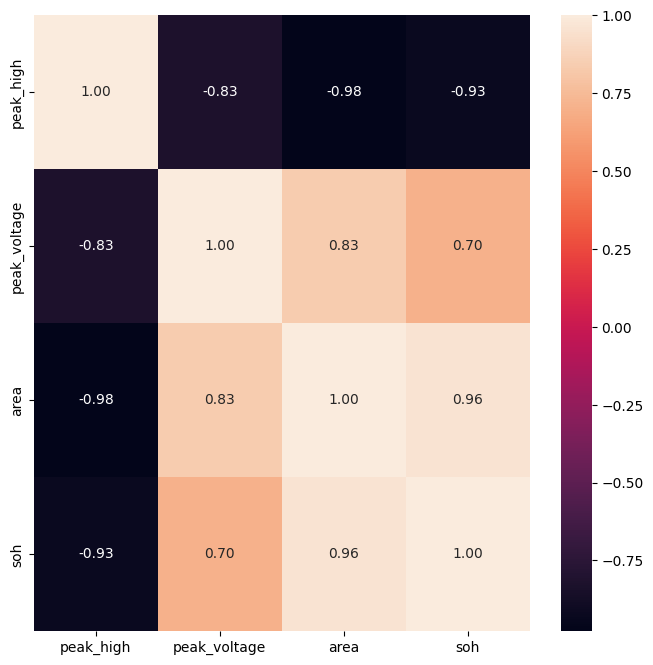

In [45]:
# we can obtain ica features before cutting data 
train_ica_full = np.concatenate([bat5.ica, bat6.ica])
y_train = np.concatenate([bat5.y, bat6.y], 0)
corr = pd.DataFrame(np.concatenate([train_ica_full, y_train.reshape(-1, 1)], 1),
                    columns=['peak_high', 'peak_voltage', 'area', 'soh'])
plt.figure(figsize=(8, 8))
sns.heatmap(corr.corr(), annot=True, fmt='.2f')
# better correlation for area

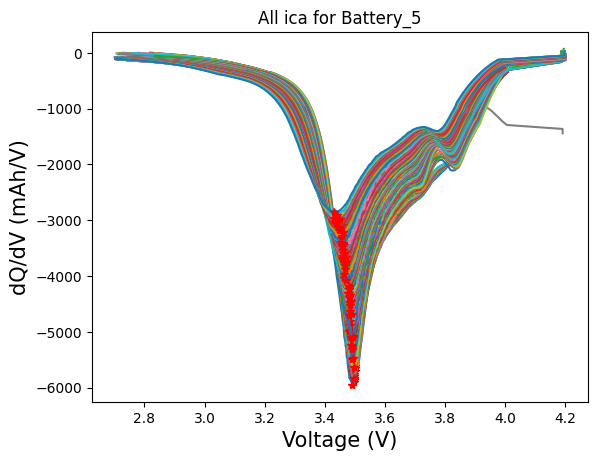

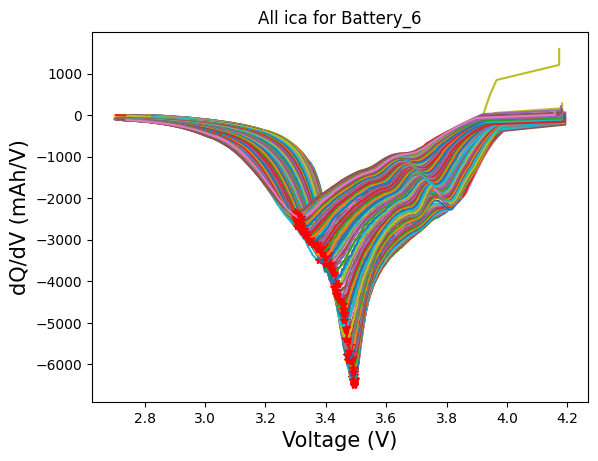

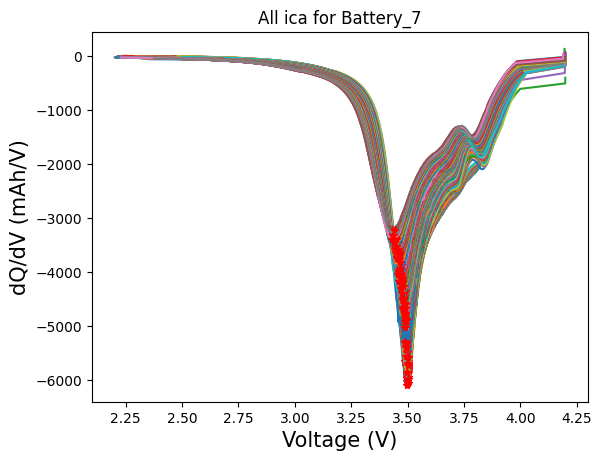

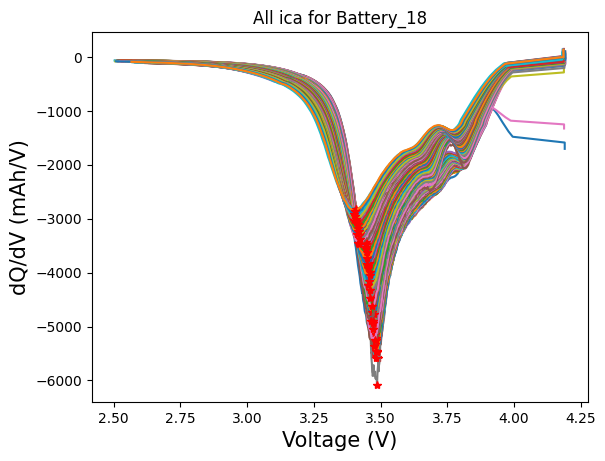

In [68]:
# seems better
for bat in bats:
    bat.build_ica()